
# Spatial Transcriptomics Analysis

In this analysis, we examine spatial transcriptomics data from a **fresh frozen invasive adenocarcinoma of the large intestine (colorectal cancer) sample, provided by 10X Genomics in collaboration with BioIVT Asterand**. The data was generated using the 10X Genomics Visium platform, which captures gene expression in spatially resolved tissue sections, allowing us to map gene activity directly onto the physical structure of the tumour.

Our primary objectives are:

1. Cluster cells based on their gene expression profiles to identify distinct cell types or functional states within the tumour.
2. Perform pathway enrichment analysis to understand the biological roles of these clusters.
3. Overlay clusters onto the original tissue image, enabling spatial visualization of different cell groups and their roles in tumour architecture.

This approach helps reveal the functional zones within the tumour, providing insight into cancer biology, tumour-immune interactions, and potential therapeutic targets.




## Data Loading


In [ ]:

import h5py
import pandas as pd
import numpy as np
import scipy.sparse as sp
import tarfile
import os

# Paths to files
h5_file_path = '/content/Parent_Visium_Human_ColorectalCancer_filtered_feature_bc_matrix.h5'
spatial_tar_path = '/content/Parent_Visium_Human_ColorectalCancer_spatial.tar.gz'

# Step 1: Load Gene Expression Data
with h5py.File(h5_file_path, 'r') as f:
    genes = [gene.decode('utf-8') for gene in f['matrix']['features']['name'][:]]  # Load gene names
    barcodes = [barcode.decode('utf-8') for barcode in f['matrix']['barcodes'][:]]  # Load barcodes
    expression_data = sp.csc_matrix((f['matrix']['data'][:],
                                     f['matrix']['indices'][:],
                                     f['matrix']['indptr'][:]),
                                    shape=f['matrix']['shape'][:]).T.toarray()

# Step 2: Load Spatial Coordinates (Optional)
with tarfile.open(spatial_tar_path, 'r:gz') as tar:
    tar.extractall(path='/content/spatial_data')
spatial_data_path = '/content/spatial_data/spatial/tissue_positions_list.csv'

if os.path.exists(spatial_data_path):
    spatial_coords = pd.read_csv(spatial_data_path, header=None)
    spatial_coords.columns = ['barcode', 'in_tissue', 'x', 'y', 'image_x', 'image_y']
    print("Spatial coordinates loaded successfully.")
else:
    print("Spatial coordinates file not found. Proceeding without spatial data.")


Spatial coordinates loaded successfully.


In [ ]:
import tarfile

# List contents of the spatial tar file to identify the correct file name
with tarfile.open(spatial_tar_path, 'r:gz') as tar:
    tar.list()


?rwxr-xr-x abigail.gallegos/unix_devs          0 2020-10-22 21:39:17 spatial/ 
?rw-r--r-- abigail.gallegos/unix_devs    4905078 2020-10-22 21:39:16 spatial/tissue_hires_image.png 
?rw-r--r-- abigail.gallegos/unix_devs        163 2020-10-22 21:39:17 spatial/scalefactors_json.json 
?rw-r--r-- abigail.gallegos/unix_devs     186139 2020-10-22 21:39:17 spatial/tissue_positions_list.csv 
?rw-r--r-- abigail.gallegos/unix_devs    1512214 2020-10-22 21:39:17 spatial/aligned_fiducials.jpg 
?rw-r--r-- abigail.gallegos/unix_devs    1610888 2020-10-22 21:39:17 spatial/detected_tissue_image.jpg 
?rw-r--r-- abigail.gallegos/unix_devs     449444 2020-10-22 21:39:16 spatial/tissue_lowres_image.png 



## K-means Clustering

We use UMAP for dimensionality reduction, followed by K-means clustering to group cells based on gene expression.


Before conduciting the clustering, I used both the Elblow method (WCSS) and the Silhouette score to decide on the optimal number of clusters.

**Elbow Method**

The Elbow Method calculates the Within-Cluster Sum of Squares (WCSS) for a range of cluster numbers (k). By plotting WCSS, you can identify the "elbow" point, where adding more clusters provides diminishing returns in terms of WCSS reduction.

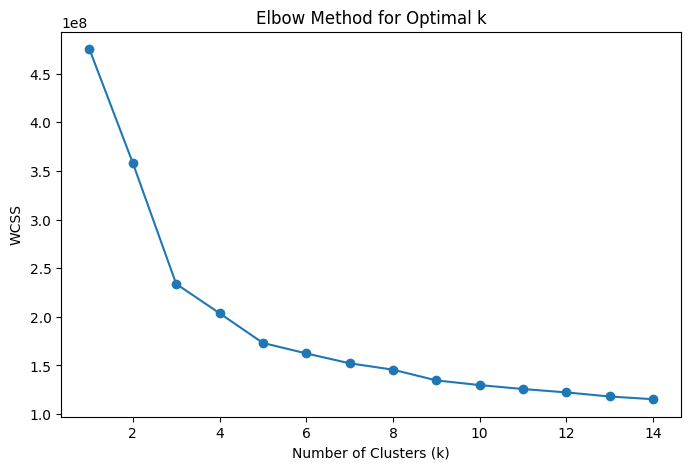

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate WCSS for a range of cluster numbers
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(expression_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.show()


**Silhouette Score**

The Silhouette Score measures how similar each cell or spot is to its cluster compared to other clusters. A higher silhouette score indicates better-defined clusters. You can use this score to evaluate different values of k.

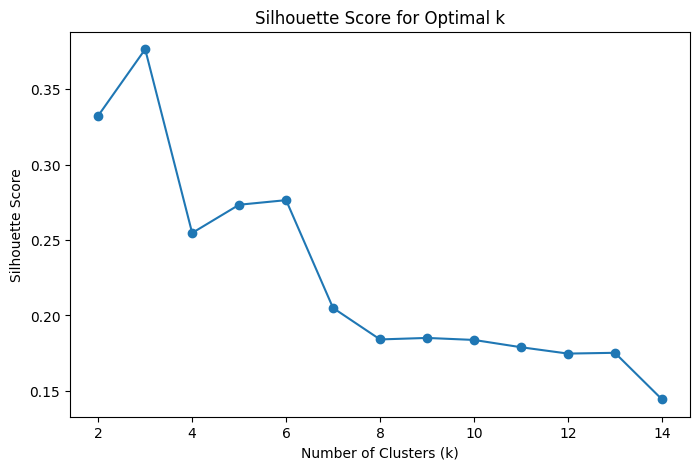

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for each number of clusters (k >= 2)
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(expression_data)
    silhouette_avg = silhouette_score(expression_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()


Based on the Elbow method and Silhouette score, I decided to use 4 clusters

In [ ]:
#!pip install umap
#!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


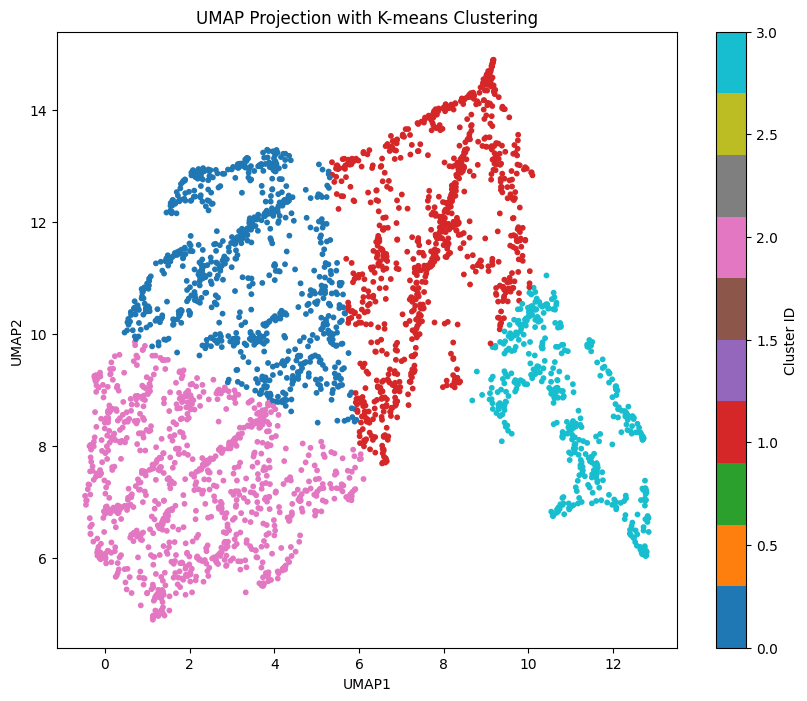

In [ ]:
import umap.umap_ as umap
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt

# Perform dimensionality reduction using UMAP
embedding = umap.UMAP(random_state=42).fit_transform(expression_data)

# K-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embedding)
clusters = kmeans.labels_

# Plot UMAP embedding with clusters
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='tab10', s=10)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Projection with K-means Clustering")
plt.colorbar(label="Cluster ID")
plt.show()



## Identifying Top Genes per Cluster

For each cluster, we calculate the mean expression of each gene and select the top genes based on mean expression.

Identifying the top genes in each cluster helps us understand the **key molecular characteristics** that define the cells or spots in that group. Each cluster represents a group of cells with similar **gene expression patterns**, which often correspond to specific cell types or functional states. By focusing on the most highly expressed genes within each cluster, we can:

1. **Characterize Cell Types**: Certain genes are markers for specific cell types (e.g., immune cells, muscle cells, etc.), allowing us to identify the types of cells present.
2. **Understand Functional Roles**: Top genes can reveal what each cell group is doing (e.g., protein synthesis, energy production, immune response).
3. **Identify Targets for Treatment**: In cancer, identifying highly expressed genes in specific regions can reveal potential targets for therapies, especially if these genes are associated with tumour growth or survival


In [ ]:

# Create a DataFrame with expression data
expression_df = pd.DataFrame(expression_data, columns=genes)
expression_df['Cluster'] = clusters

# Identify the top genes per cluster
top_genes_per_cluster = {}
for cluster_id in np.unique(clusters):
    cluster_data = expression_df[expression_df['Cluster'] == cluster_id].drop('Cluster', axis=1)
    mean_expression = cluster_data.mean(axis=0)
    top_genes = mean_expression.nlargest(10).index.tolist()
    top_genes_per_cluster[cluster_id] = top_genes

# Display the top genes per cluster
print("Top genes per cluster:", top_genes_per_cluster)


Top genes per cluster: {0: ['RPS19', 'RPS21', 'RPS4X', 'EEF1A1', 'RPL41', 'RPL39', 'FTH1', 'RPL10', 'RPLP1', 'RPL13A'], 1: ['MT-CO2', 'MT-CO3', 'MT-CO1', 'MT-ND4', 'RPS21', 'RPS19', 'RPL39', 'MT-ND1', 'MT-ND3', 'MT-ATP6'], 2: ['RPS19', 'RPS21', 'MT-CO2', 'RPL39', 'RPL41', 'EEF1A1', 'MT-CO3', 'MT-CO1', 'RPS4X', 'RPL10'], 3: ['IGKC', 'IGHG4', 'MT-CO2', 'IGLC2', 'IGHG1', 'MT-CO3', 'MT-CO1', 'RPS19', 'EEF1A1', 'MT-ND4']}


**Cluster 0 Genes: High Ribosomal Activity**
* *RPS19, RPS21, RPS4X, RPL41, RPL39, RPL10, RPLP1, RPL13A*: These genes encode ribosomal proteins, which are essential components of ribosomes, the cellular machinery responsible for protein synthesis. High expression of ribosomal proteins often indicates that these cells are highly active in protein production, possibly due to rapid growth or a need for increased metabolic activity.
* *EEF1A1:* This gene encodes elongation factor 1-alpha, a protein that helps with the elongation phase of protein synthesis, ensuring efficient translation of mRNA into proteins.
* *FTH1:* Encodes the ferritin heavy chain, which is involved in iron storage and regulation, helping to protect cells from iron toxicity and oxidative stress.
**Interpretation:** Cluster 0 appears to have cells with high protein synthesis activity, possibly proliferative or metabolically active cells.

**Cluster 1 Genes: Mitochondrial Function and Energy Production**
* *MT-CO2, MT-CO3, MT-CO1*: These genes encode components of cytochrome c oxidase (COX) in the mitochondrial respiratory chain, which is crucial for energy production via oxidative phosphorylation.
* *MT-ND4, MT-ND1, MT-ND3*: These genes encode components of NADH dehydrogenase (complex I), another critical part of the mitochondrial respiratory chain for ATP production.
* *MT-ATP6*: Encodes a subunit of ATP synthase, which is directly responsible for the production of ATP, the cell’s main energy molecule.
* *RPS21, RPS19, RPL39*: Ribosomal proteins, as seen in Cluster 0, indicating that these cells are also active in protein synthesis.
**Interpretation:** Cluster 1 is enriched in mitochondrial and energy-producing genes, suggesting cells with high metabolic demands, possibly linked to active growth or energy-intensive processes in the tumour.

**Cluster 2 Genes: Combination of Ribosomal and Mitochondrial Activity**
* *RPS19, RPS21, RPS4X, RPL41, RPL39, RPL10*: Ribosomal proteins involved in protein synthesis.
* *MT-CO2, MT-CO3, MT-CO1*: Mitochondrial genes, as in Cluster 1, important for energy production.
* *EEF1A1*: Elongation factor involved in protein synthesis.
**Interpretation:** Cluster 2 shows a combination of ribosomal and mitochondrial gene expression, suggesting cells that require both high protein synthesis and energy production, possibly for rapid proliferation or adaptive responses.

**Cluster 3 Genes: Immune-Related and Mitochondrial**
* *IGKC, IGHG4, IGLC2, IGHG1*: These genes are immunoglobulin (antibody) genes, indicating immune cells, likely B cells or plasma cells, that are involved in the immune response.
* *MT-CO2, MT-CO3, MT-CO1, MT-ND4*: Mitochondrial genes important for energy production, similar to those in Clusters 1 and 2.
* *RPS19, EEF1A1*: Ribosomal protein and elongation factor, supporting protein synthesis.
**Interpretation:** Cluster 3 appears to contain immune cells, particularly antibody-producing cells, along with some mitochondrial and ribosomal activity. This suggests immune cell infiltration within the tumour, possibly related to the body’s immune response to the cancer.

**Summary of Each Cluster's Role:**
* Cluster 0: Cells with high ribosomal activity, likely involved in rapid protein synthesis.
* Cluster 1: Cells with high mitochondrial activity, suggesting high energy demands.
* Cluster 2: Cells that combine both ribosomal and mitochondrial activity, indicating a need for both protein synthesis and energy.
* Cluster 3: Likely immune cells (antibody-producing), potentially part of the body’s immune response against the tumour.

**How This Informs Cancer Understanding and Treatment:**

Understanding which genes are highly expressed in each cluster gives us clues about the different roles of cell populations within the tumour:

* **Proliferative Regions (Clusters 0 and 2)** might be targeted by treatments that inhibit protein synthesis or cell division.
* **High-Energy Cells (Cluster 1)** may respond to therapies that target mitochondrial function or disrupt energy production.
* **Immune Cells (Cluster 3)** could be relevant for immunotherapy approaches, as their presence suggests an immune response that could potentially be boosted to fight the tumour.

  


## Pathway Enrichment Analysis

We use the top genes from each cluster to perform pathway enrichment using GProfiler.

Pathway enrichment analysis is used to interpret gene expression data, especially in complex samples like tumours. Rather than looking at individual genes, pathway enrichment allows us to see the "bigger picture" by identifying biological pathways or processes that are active within groups of genes. It does the following:
* Provides a functional overview of cell groups.
* Helps identify cell types, states, and disease mechanisms.
* Guides treatment by pinpointing actionable pathways.
* Simplifies data interpretation, making large datasets more manageable.

In [ ]:
#!pip install gprofiler-official


In [ ]:

from gprofiler.gprofiler import GProfiler

# Initialize GProfiler
gp = GProfiler(return_dataframe=True)
enrichment_results = {}

# Perform pathway enrichment for each cluster
for cluster, genes in top_genes_per_cluster.items():
    results = gp.profile(organism='hsapiens', query=genes)
    enrichment_results[cluster] = results
    print(f"Cluster {cluster} Enrichment Results:")
    print(results[['name', 'p_value', 'source']].head(10))  # Display top 10 pathways


Cluster 0 Enrichment Results:
                                                name       p_value source
0                                 cytosolic ribosome  2.626331e-18  GO:CC
1                           Peptide chain elongation  3.389589e-16   REAC
2                  Eukaryotic Translation Elongation  5.103305e-16   REAC
3                                  ribosomal subunit  1.373242e-13  GO:CC
4                             Viral mRNA Translation  2.001721e-13   REAC
5                           Selenocysteine synthesis  2.872644e-13   REAC
6                 Eukaryotic Translation Termination  2.872644e-13   REAC
7  Nonsense Mediated Decay (NMD) independent of t...  3.420827e-13   REAC
8                            cytoplasmic translation  4.045259e-13  GO:BP
9  Response of EIF2AK4 (GCN2) to amino acid defic...  5.651742e-13   REAC
Cluster 1 Enrichment Results:
                                                name       p_value source
0             Abnormal mitochondria in muscle tissue

**Overall Insights**
* Tumour Growth and Maintenance: Clusters 0 and 2 show high protein synthesis, likely involved in supporting tumour growth and maintenance.
* Metabolic Demands: Cluster 1’s focus on mitochondrial and energy pathways highlights a subgroup with high metabolic demands, potentially a more aggressive part of the tumour.
* Immune Involvement: Cluster 3’s immune and inflammatory pathways indicate immune cell presence, which could be leveraged by immunotherapy.

# Spatial Distribution Visualisation

Spatial distribution visualisation allows us to do the following:

* Mapping Functional Zones in Tumour Architecture:
* Identifying Microenvironments:
* Visualizing Interaction Zones:
* Aligning Molecular Data with Histology:


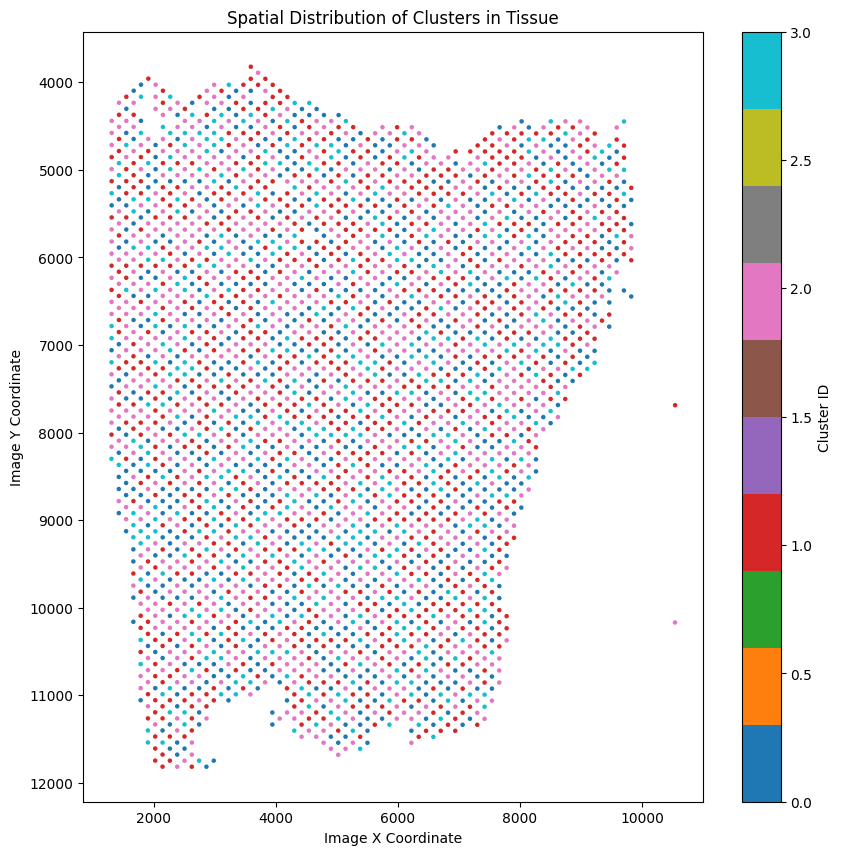

In [ ]:
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the tar.gz file and the extraction directory
spatial_tar_path = '/content/Parent_Visium_Human_ColorectalCancer_spatial.tar.gz'
extraction_path = '/content/spatial_data'

# Step 1: Extract the spatial data
with tarfile.open(spatial_tar_path, 'r:gz') as tar:
    tar.extractall(path=extraction_path)

# Step 2: Load the spatial coordinates file (tissue_positions_list.csv)
spatial_coords_path = f'{extraction_path}/spatial/tissue_positions_list.csv'
spatial_coords = pd.read_csv(spatial_coords_path, header=None)
spatial_coords.columns = ['barcode', 'in_tissue', 'x', 'y', 'image_x', 'image_y']

# Filter to keep only cells that are in the tissue
spatial_coords = spatial_coords[spatial_coords['in_tissue'] == 1]

# Step 3: Add cluster labels to the DataFrame (ensure `clusters` matches the order of barcodes)
spatial_coords['Cluster'] = clusters

# Step 4: Visualize the spatial distribution of clusters
plt.figure(figsize=(10, 10))
scatter = plt.scatter(spatial_coords['image_x'], spatial_coords['image_y'], c=spatial_coords['Cluster'], cmap='tab10', s=5)
plt.gca().invert_yaxis()  # Invert y-axis for correct orientation
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("Image X Coordinate")
plt.ylabel("Image Y Coordinate")
plt.title("Spatial Distribution of Clusters in Tissue")
plt.show()


**Overlay Cluster Visualization on Tissue Image**

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (177742224 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


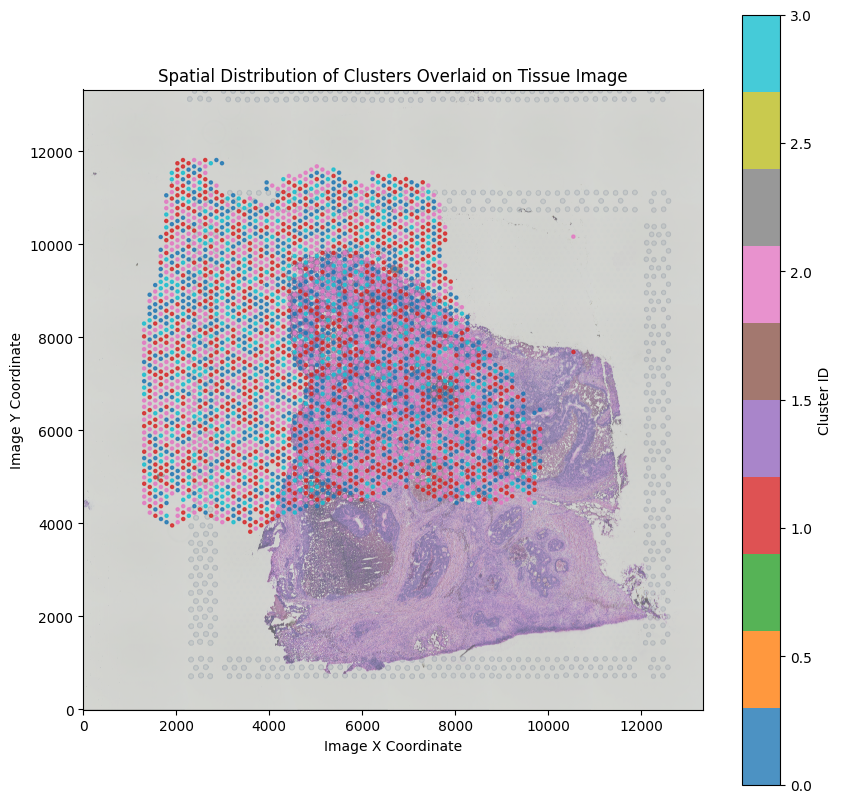

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the high-resolution tissue image
tissue_image_path = '/content/Parent_Visium_Human_ColorectalCancer_image.tif'
tissue_image = Image.open(tissue_image_path)

# Plot the tissue image with clusters overlaid
plt.figure(figsize=(10, 10))
plt.imshow(tissue_image, alpha=0.6)  # Show tissue image with some transparency
scatter = plt.scatter(spatial_coords['image_x'], spatial_coords['image_y'],
                      c=spatial_coords['Cluster'], cmap='tab10', s=5, alpha=0.8)
plt.gca().invert_yaxis()  # Invert y-axis for correct orientation
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("Image X Coordinate")
plt.ylabel("Image Y Coordinate")
plt.title("Spatial Distribution of Clusters Overlaid on Tissue Image")
plt.show()



# **Conclusion**

This analysis of spatial transcriptomics data identifies distinct clusters of cells based on gene expression and explores their biological significance through pathway enrichment, and finally maps it into the original image using spacial distribution, from a sample of human Colorectal cancer.



## **Applications of this Analysis:**

In the context of drug discovery and precision medicine, this spatial transcriptomics analysis of a human colorectal cancer sample provides key insights that could guide therapeutic development and personalized treatment strategies:

### 1. **Identification of Functional Zones in the Tumour:**
  By clustering cells based on gene expression and mapping them spatially, we identified distinct regions within the tumour with unique biological functions. For instance, clusters enriched in **protein synthesis** and **ribosomal activity** likely represent **proliferative zones**, where rapid cell division is fueling tumour growth.
  
  **Suggestions:** Targeting these proliferative zones with **protein synthesis inhibitors** or **anti-proliferative drugs** could disrupt the tumour’s expansion.
<br><br>

### 2. **Metabolic Vulnerabilities:**
  Clusters with **high mitochondrial activity** and **oxidative phosphorylation** point to cells with **increased energy demands**, often characteristic of cancer cells adapting to a nutrient-limited microenvironment.
  
  **Suggestions:** These findings suggest potential metabolic vulnerabilities that could be targeted by **metabolic inhibitors** to reduce the energy supply essential for tumour survival, especially in well-vascularized or highly proliferative regions.
<br><br>

### 3. **Immune Cell Localization and Immune Microenvironment:**
  The spatial distribution of **immune cell-related genes**, especially in Cluster 3, highlights areas where immune cells are present within or around the tumour. This cluster includes pathways related to **immunoglobulins**, suggesting the presence of **antibody-producing B cells** or other immune cells actively responding to the tumour.
  

  **Suggestions:** **Immunotherapies** could be effective if they amplify these immune responses or improve immune cell infiltration into the tumour, potentially increasing the tumour’s vulnerability to immune attack.
<br><br>

### 4. **Pathway-Specific Insights for Targeted Therapies:**
The pathway enrichment analysis revealed overactive pathways associated with **protein synthesis**, **mitochondrial function**, and **immune signalling**. These pathways could serve as therapeutic targets, where pathway-specific inhibitors or combination therapies may be explored.


**Suggestions:** **Protein synthesis inhibitors** could target clusters with **high ribosomal activity**.
**Mitochondrial inhibitors** may affect clusters relying on **oxidative phosphorylation**.
**Immune checkpoint inhibitors** or **CAR-T cell therapies** could be enhanced by **targeting immune-enriched regions** of the tumour.
<br><br>

### 5. **Implications for Precision Medicine:**
Mapping the functional and spatial heterogeneity of the tumour offers a roadmap for personalized treatment by identifying which pathways and cell types are active in specific tumour regions.

**Suggestions:** By tailoring therapies to the specific characteristics of each cluster, we could potentially improve treatment outcomes. For example, targeting proliferative clusters aggressively while supporting immune activation could offer a dual approach to shrink the tumour and bolster the body's own defenses.
